In [1]:
import urllib.request
import zipfile
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
from pathlib import Path

import torchvision

import time
import pickle
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

torch.manual_seed(318595386)

In [2]:
# import csv
# # load the train and test samples
# with open(f'train.txt', 'r') as f:
#     train = list(csv.reader(f, delimiter='\t'))[1:]
# with open(f'test.txt', 'r') as f:
#     test= list(csv.reader(f, delimiter='\t'))[1:]

In [2]:
url_test ="http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt"
url_train= "http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt"

In [3]:
import torch
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [4]:
def get_data(url_train,url_test):
    """
    Get the train and test data ready for the model
    Parameters:
    ----------
    url_train : URL path of train file
    url_test : URL path of test  file

    Returns:
    ----------
    train- list of tuple with all the pers (name1, index_img1, name2, index_img2)
    test - list of tuple with all the pers (name1, index_img1, name2, index_img2)
    """
    result = []
    openfile_train = urllib.request.urlopen(url_train)
    openfile_test = urllib.request.urlopen(url_test)
    openfiles = [openfile_train, openfile_test ]
    for openfile in openfiles:
      for line in openfile: # get dataset length
        decoded_line = line.decode("utf-8")
        dataset_length = int(decoded_line)
        break
      dataset = []
      counter = dataset_length * 2
      for line in openfile: # get input images
        if counter == 0:
          break

        data_list = []
        decoded_line = line.decode("utf-8")
        data_list = decoded_line.split("\t")

        if len(data_list) == 3: # same person
          name, img1, img2 = data_list[0], data_list[1], data_list[2].split("\n")[0]
          dataset.append((name, img1, name, img2, 1))
        elif len(data_list) == 4:
          name1, img1, name2 ,img2 = data_list[0], data_list[1], data_list[2], data_list[3].split("\n")[0]
          dataset.append((name1, img1, name2, img2, 0))
      result.append(dataset)

    return result[0], result[1]

In [5]:
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomCropTransform:
    """
    Custom image transformation class for cropping images.
    Args: border_pixels (int): Number of pixels to keep around the border of the image.
    """

    def __init__(self, border_pixels):
        self.border_pixels = border_pixels

    def __call__(self, image):
        """
        Apply the custom crop transformation to the input image.
        Args: image (PIL.Image.Image): Input image.
        Returns: PIL.Image.Image: Cropped image.
        """
        width, height = image.size
        left, top, right, bottom = ( self.border_pixels,self.border_pixels,width - self.border_pixels, height - self.border_pixels,)
        cropped_image = image.crop((left, top, right, bottom))
        return cropped_image

class MyDataset(Dataset):
    """
    Custom PyTorch Dataset class for handling image pairs and their labels.

    Args: data (list): List of data samples, where each sample is a tuple containing information
                    about two images and their corresponding label.

    Attributes: data (list): List of data samples.
                transform (torchvision.transforms.Compose): Composition of image transformations.
    """

    def __init__(self, data):
        self.data = data
        
        self.transform = transforms.Compose([
            CustomCropTransform(25),
            transforms.Resize((105, 105)),  # Resize to 105x105 pixels
            transforms.ToTensor(),          # Convert to a PyTorch tensor
            transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
        ])

    def __len__(self):
        """
        Get the total number of samples in the dataset.
        Returns: int: Number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.
        Args:idx (int): Index of the sample to retrieve.
        Returns: tuple: Tuple containing two images and their label.
        """
        sample = self.data[idx]
        label = sample[-1]
        path = './lfw2/lfw2/'
        name, img1, name2, img2 = sample[0], sample[1], sample[2], sample[3]

        img1 = '_' + '0' * (4 - len(str(img1))) + img1
        path_1 = path + name + '/' + name + img1 + '.jpg'  # getting the path for img1
        pil_img1 = Image.open(path_1)
        x1 = self.transform(pil_img1)

        img2 = '_' + '0' * (4 - len(str(img2))) + img2
        path_2 = path + name2 + '/' + name2 + img2 + '.jpg'  # getting the path for img2
        pil_img2 = Image.open(path_2)
        x2 = self.transform(pil_img2)

        return x1, x2, torch.tensor(label)

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

def count_samples(data_rows):
    same_person = sum([1 for row in data_rows if row[4] == 1])
    different_person = len(data_rows) - same_person
    return same_person, different_person

trainn, test = get_data(url_train,url_test)

# split to train ans test
train, val = train_test_split(trainn, test_size=0.15, random_state=42) # 15% go to validation set
train_same, train_not = count_samples(train)
val_same, val_not = count_samples(val)
test_same, test_not = count_samples(test)

print("Number of samples with the Same person:")
print("Train set:     ", train_same)
print("Validation set:", val_same)
print("Test set:      ", test_same, "\n")

print("Number of samples with Different persons:")
print("Train set:     ", train_not)
print("Validation set:", val_not)
print("Test set:      ", test_not, "\n")


Number of samples with the Same person:
Train set:      926
Validation set: 174
Test set:       500 

Number of samples with Different persons:
Train set:      944
Validation set: 156
Test set:       500 



In [12]:
import torch.nn as nn
import torch.nn.functional as F

class SiameseCNN(nn.Module):
    """
    This network takes an image as input and outputs a vector of size 128.
    The vector encodes the image into a space where images of the same person are closer to each other
    and images of different persons are further away.

    The network is based on the paper: "Siamese Neural Networks for One-shot Image Recognition"
    by Koch et al.

    The paper describes the network architecture and training procedure in detail.

    """

    def __init__(self, use_batch_norm=False, use_dropout=False, dropout_rate=0.0):
        super(SiameseCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=10, stride=1, padding=0) # convolutional layers
        self.bn1 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity() # batch normalization layers
        self.dropout1 = nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity()  # dropout layers

        self.conv2 = nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=0) # convolutional layers
        self.bn2 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity() # batch normalization layers
        self.dropout2 = nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity() # dropout layers

        self.conv3 = nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=0) # convolutional layers
        self.bn3 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity() # batch normalization layers
        self.dropout3 = nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity() # dropout layers

        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0) # convolutional layers
        self.bn4 = nn.BatchNorm2d(256) if use_batch_norm else nn.Identity() # batch normalization layers
        self.dropout4 = nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity()# dropout layers
        
        # fully connected and dropout layers
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc_dropout = nn.Dropout(dropout_rate) if use_dropout else nn.Identity()
        self.fc2 = nn.Linear(4096, 1)
        self.pool = nn.MaxPool2d(2) # max-pooling layer

    def forward_once(self, x):
        """
        Forward pass through one branch of the Siamese CNN.
        Args: x (torch.Tensor): Input image tensor.
        Returns: torch.Tensor: Embeddings for the input image.
        """
        x_conv = self.conv1(x)
        x_nb = self.bn1(x_conv)
        x_relu = F.relu(x_nb)
        x_drop = self.pool(x_relu)
        x = self.dropout1(x_drop)

        x = self.conv2(x)
        x_nb = self.bn2(x)
        x_relu = F.relu(x_nb)
        x_drop = self.pool(x_relu)
        x = self.dropout2(x_drop)

        x = self.conv3(x)
        x_nb = self.bn3(x)
        x_relu = F.relu(x_nb)
        x_drop = self.pool(x_relu)
        x = self.dropout3(x_drop)

        x = self.conv4(x)
        x_nb = self.bn4(x)
        x_relu = F.relu(x_nb)
        x = self.dropout4(x_relu)

        x = x.view(x.size(0), -1)  # Flatten the output

        # Fully connected layers:
        x = self.fc1(x)
        x = self.fc_dropout(x)
        x = torch.sigmoid(x)

        return x

    def forward(self, input1, input2):
        """
        Forward pass through the Siamese CNN for a pair of input images.

        Args:
            input1 (torch.Tensor): Tensor for the first input image.
            input2 (torch.Tensor): Tensor for the second input image.

        Returns:
            torch.Tensor: Similarity score indicating the similarity between the two input images.
        """
        output1 = self.forward_once(input1) # embeddings for pic1
        output2 = self.forward_once(input2) # embeddings for pic2
        l1_distance = torch.abs(output1 - output2)  # calculate the L1 distance 
        similarity_score = torch.sigmoid(self.fc2(l1_distance)) # pass the L1 to fully connected layer

        return similarity_score

# instantiate the network with separate options for batch normalization and dropout
model = SiameseCNN()



In [14]:
from torch.optim import lr_scheduler

def result(batch_size, lr, use_batch_norm, use_dropout, train, val,test, dropout_rate ):
    """
    Train a Siamese Neural Network model and evaluate its performance on training, validation, and test sets.

    Args:
        batch_size (int): Number of samples in each mini-batch.
        lr (float): Learning rate for the optimizer.
        use_batch_norm (bool): Flag to indicate whether to use batch normalization in the model.
        use_dropout (bool): Flag to indicate whether to use dropout in the model.
        train (list): Training dataset.
        val (list): Validation dataset.
        test (list): Test dataset.
        dropout_rate (float): Dropout rate if use_dropout is True.

    Returns:
        tuple: Tuple containing lists of training and validation losses, and training and validation accuracies.
    """
    s = time.time()
   
    EPOCHS = 100
    best_accuracy = 0
    exp = 3
    momentum = 0.5
    seed = 42
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_set = MyDataset(train)
    val_set = MyDataset(val)
    test_set = MyDataset(test)
    acc_train, loss_train = [], []
    acc_val, loss_val = [], []
    early_stop_epochs = 10
    best_epoch = -1
    
    
    val_loader = DataLoader(dataset = val_set, batch_size=batch_size)
    train_loader = DataLoader(dataset = train_set, batch_size=batch_size)
    test_loader = DataLoader(dataset = test_set, batch_size=batch_size)
    
  
    model = SiameseCNN(use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout_rate= dropout_rate)
    model.to(device)
    #ADAM
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    #SGD
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    criterion = nn.BCELoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        model.train()
        running_loss , avg_accuracy_train= 0.0, 0.0
        count= 0
    
        for step, (x1, x2, y) in enumerate(train_loader):
            y = y.to(dtype=torch.float32)
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x1, x2)
            # computing the loss function
            losss = criterion(pred, y.unsqueeze(1))
            labeled_pred_train = pred > 0.5
            correct = (labeled_pred_train == y.unsqueeze(1)).float()     
            accuracy = correct.sum() / len(correct)
            
            # Backpropagation and updating the weights
            losss.backward()
            optimizer.step()
    
            running_loss += losss.item()
            avg_accuracy_train += accuracy.item()
            count+= 1
    
            # if step % 10 == 0:
            #   print(f'Epoch: {epoch}, Step: {step}, Loss: {losss.item()\step}')
        # print("count", count, "avg_accuracy_train",avg_accuracy_train, "len(train_loader)", len(train_loader))
    
        train_loss = running_loss / len(train_loader)
        train_acc = avg_accuracy_train / len(train_loader)
        
        acc_train.append(train_acc)
        loss_train.append(train_loss)
        
        with torch.no_grad():
            model.eval()
        
            avg_accuracy_val, avg_loss_val = 0, 0
            for x1, x2, y in val_loader:
                
                y = y.to(dtype=torch.float32)
                x1, x2, y = x1.to(device), x2.to(device), y.to(device)
                
                pred = model(x1, x2)
                losss = criterion(pred, y.unsqueeze(1))

                labeled_pred_train = pred > 0.5
                correct = (labeled_pred_train == y.unsqueeze(1)).float()
                accuracy = correct.sum() / len(correct)
                avg_loss_val += losss.item()
                avg_accuracy_val += accuracy.item()
        val_acc = avg_accuracy_val / len(val_loader)
        val_loss = avg_loss_val / len(val_loader)
        acc_val.append(val_acc)
        loss_val.append(val_loss)
    
        
        # print(f'Epoch: {epoch} Test Loss: {metrics_loss} Test Accuracy: {metrics_acc}')
        if round(val_loss,7) < best_val_loss:
                best_val_loss = round(val_loss,7)
                best_epoch = epoch
        test_acc = 0.0
        model.eval()
        with torch.no_grad():
            for x1, x2, y in test_loader:
                y = y.to(dtype=torch.float32)
    
                # y = y.reshape((x1.size()[0], 1, 1)).to(dtype=torch.float32)
                x1, x2, y = x1.to(device), x2.to(device), y.to(device)
                pred = model(x1, x2)
    
                labeled_pred_train = pred > 0.5
                correct = (labeled_pred_train == y.unsqueeze(1)).float()
                accuracy = correct.sum() / len(correct)
                test_acc += accuracy.item()
            
    
        test_acc_fin = test_acc / len(test_loader)
     
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc_fin:.4f}")
        
        if epoch - best_epoch >= early_stop_epochs:
            # print(f"Stopping early at epoch {epoch + 1} due to no improvement in validation loss for {early_stop_epochs} consecutive epochs.")
            break
        scheduler.step()       
    
    f = time.time()
    print(f"Epoch {epoch}, batch_size:{batch_size}, lr:{lr}, Batch norm:{use_batch_norm}, Dropout:{use_dropout}, D_rate:{dropout_rate}, Train Loss:{train_loss:.4f}, Train Acc:{train_acc:.4f}, Val Loss:{val_loss:.4f}, Val Acc:{val_acc:.4f}, Test Acc:{test_acc_fin:.4f}, Time:{f-s:.4f}")

   
    return loss_train, loss_val, acc_train, acc_val

In [17]:
loss_train, loss_val, acc_train, acc_val = result(16, 0.000005 , True, False, train, val,test, 0.0 )

Epoch 0, Train Loss: 0.6867, Train Acc: 0.5641, Val Loss: 0.6820, Val Acc: 0.5577, Test Acc: 0.5794
Epoch 1, Train Loss: 0.6395, Train Acc: 0.7945, Val Loss: 0.6715, Val Acc: 0.5595, Test Acc: 0.5883
Epoch 2, Train Loss: 0.6007, Train Acc: 0.8689, Val Loss: 0.6610, Val Acc: 0.6060, Test Acc: 0.6071
Epoch 3, Train Loss: 0.5651, Train Acc: 0.9096, Val Loss: 0.6510, Val Acc: 0.6089, Test Acc: 0.6329
Epoch 4, Train Loss: 0.5317, Train Acc: 0.9315, Val Loss: 0.6418, Val Acc: 0.6464, Test Acc: 0.6597
Epoch 5, Train Loss: 0.4999, Train Acc: 0.9508, Val Loss: 0.6336, Val Acc: 0.6512, Test Acc: 0.6677
Epoch 6, Train Loss: 0.4693, Train Acc: 0.9593, Val Loss: 0.6262, Val Acc: 0.6661, Test Acc: 0.6776
Epoch 7, Train Loss: 0.4396, Train Acc: 0.9674, Val Loss: 0.6195, Val Acc: 0.6690, Test Acc: 0.6806
Epoch 8, Train Loss: 0.4108, Train Acc: 0.9781, Val Loss: 0.6133, Val Acc: 0.6780, Test Acc: 0.6885
Epoch 9, Train Loss: 0.3828, Train Acc: 0.9824, Val Loss: 0.6076, Val Acc: 0.6899, Test Acc: 0.6905


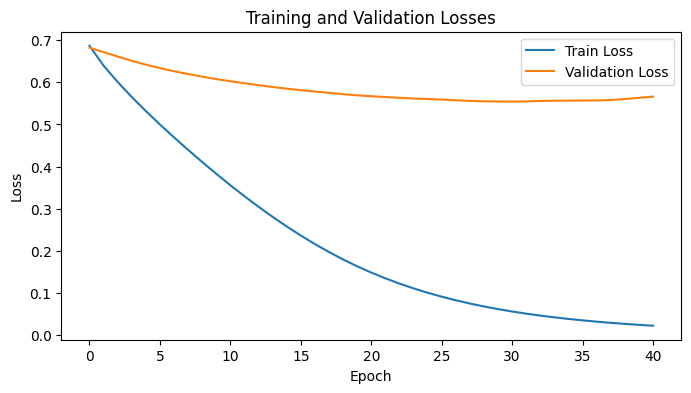

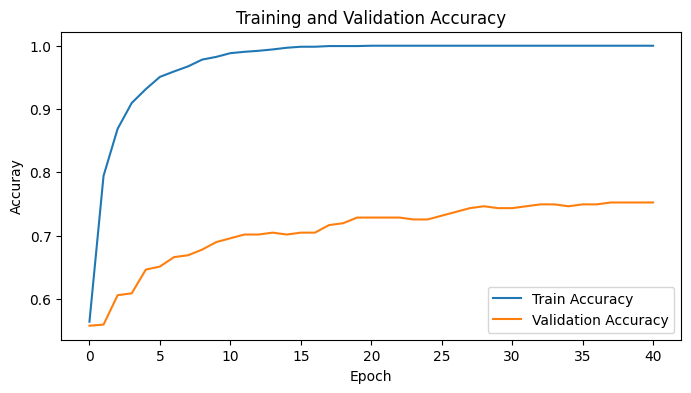

In [18]:
import matplotlib.pyplot as plt

# Plot training and validation Loss
plt.figure(figsize=(8, 4))
plt.plot(loss_train, label='Train Loss')
plt.plot(loss_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

# Plot training and validation Accuracy
plt.figure(figsize=(8, 4))
plt.plot(acc_train, label='Train Accuracy')
plt.plot(acc_val, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuray')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [36]:
print("Starting grid search")
use_dropout = False
res = []
for batch_size in [16,64, 128]:
  for batchnorm in [True, False]:
    for learning_rate in [0.01, 0.0005, 0.000005]:
        loss_train, loss_val, acc_train, acc_val = result(batch_size, learning_rate , batchnorm, use_dropout, train, val,test, 0.0 )
        res.append([loss_train, loss_val, acc_train, acc_val])


Starting grid search
Epoch 12, batch_size:16, lr:0.01, Batch norm:True, Dropout:False, D_rate:0.0, Train Loss:0.6783, Train Acc:0.5823, Val Loss:0.6900, Val Acc:0.5780, Test Acc:0.5437, Time:162.8257
Epoch 15, batch_size:16, lr:0.0005, Batch norm:True, Dropout:False, D_rate:0.0, Train Loss:0.0818, Train Acc:0.9792, Val Loss:0.8302, Val Acc:0.6542, Test Acc:0.6508, Time:197.7978
Epoch 39, batch_size:16, lr:5e-06, Batch norm:True, Dropout:False, D_rate:0.0, Train Loss:0.0244, Train Acc:1.0000, Val Loss:0.5620, Val Acc:0.7524, Test Acc:0.7123, Time:512.8878
Epoch 14, batch_size:16, lr:0.01, Batch norm:False, Dropout:False, D_rate:0.0, Train Loss:0.5806, Train Acc:0.6927, Val Loss:0.8245, Val Acc:0.5577, Test Acc:0.5516, Time:181.0400
Epoch 16, batch_size:16, lr:0.0005, Batch norm:False, Dropout:False, D_rate:0.0, Train Loss:0.1642, Train Acc:0.9476, Val Loss:0.7762, Val Acc:0.6625, Test Acc:0.6687, Time:203.6166
Epoch 19, batch_size:16, lr:5e-06, Batch norm:False, Dropout:False, D_rate:0.

In [69]:
# Find indices of TP, TN, FP, and FN

import seaborn as sns
import seaborn as sns

from sklearn.metrics import confusion_matrix
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

all_preds = []
all_labels = []
all_probs = []
batch_size = 128

test_set = MyDataset(test)

test_loader = DataLoader(dataset = test_set, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseCNN(use_batch_norm=True, use_dropout=False, dropout_rate= 0)
model.to(device)


# Set model to evaluation mode
model.eval()
# def predict(test_loader):
with torch.no_grad():
    for x1, x2, y in test_loader:
        x1, x2 = x1.to(device), x2.to(device)
        pred = model(x1, x2)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(pred.cpu().numpy())
    # return np.array(all_preds), np.array(all_labels), np.array(all_probs)
# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Find indices of TP, TN, FP, and FN
fixed_predictions_proba = np.where(all_probs > 0.5, 1, 0)
y_pred_list = [row[0] for row in fixed_predictions_proba]
y_test_list = [int(y) for y in all_labels]
true_pos = [i for i, y in enumerate(y_pred_list) if y_test_list[i] == y_pred_list[i] and  y_test_list[i] == 1]
true_neg = [i for i, y in enumerate(y_pred_list) if y_test_list[i] == y_pred_list[i] and  y_test_list[i] == 0]
false_pos = [i for i, y in enumerate(y_pred_list) if y_test_list[i] != y_pred_list[i] and  y_test_list[i] == 0]
false_neg = [i for i, y in enumerate(y_pred_list) if y_test_list[i] != y_pred_list[i] and  y_test_list[i] == 1]

In [53]:
print(tp_index,
tn_index ,
fp_index ,
fn_index )

499 992 999 498


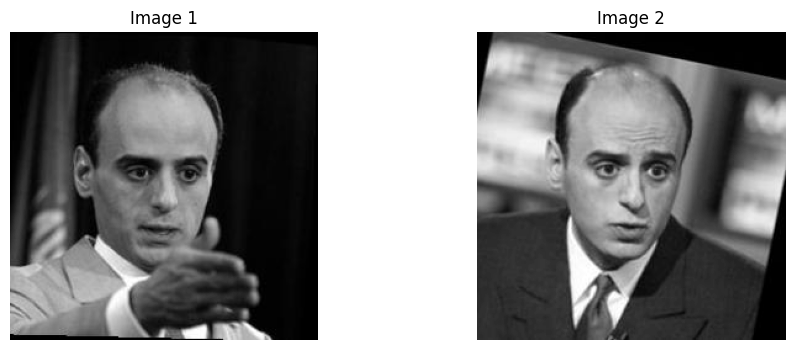

In [101]:
def plot_images(sample, index):
    sample = sample[index]
    label = sample[-1]
    path = './lfw2/lfw2/'
    name, img1, name2, img2 = sample[0], sample[1], sample[2], sample[3]

    img1 = '_' + '0' * (4 - len(str(img1))) + img1
    path_1 = path + name + '/' + name + img1 + '.jpg'  # getting the path for img1

    img2 = '_' + '0' * (4 - len(str(img2))) + img2
    path_2 = path + name2 + '/' + name2 + img2 + '.jpg'  # getting the path for img1
    im = Image.open(path_1)
    im2 = Image.open(path_2)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(im, cmap='gray')
    plt.title("Image 1")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(im2, cmap='gray')
    plt.title("Image 2")
    plt.axis('off')
    
    plt.subplots_adjust(wspace=0.01)
    plt.show()
trainn, test = get_data(url_train,url_test)

plot_images(test, 3)

In [ ]:
| Epoch | Batch Size | Learning Rate | Batch Norm | Dropout | Dropout Rate | Train Loss | Train Acc | Val Loss | Val Acc | Test Acc | Time     |
|-------|------------|---------------|------------|---------|--------------|------------|-----------|----------|---------|----------|----------|
| 12    | 16         | 0.01          | True       | False   | 0.0          | 0.6783     | 0.5823    | 0.69     | 0.578   | 0.5437   | 162.8257 |
| 15    | 16         | 0.0005        | True       | False   | 0.0          | 0.0818     | 0.9792    | 0.8302   | 0.6542  | 0.6508   | 197.7978 |
| 39    | 16         | 5e-06         | True       | False   | 0.0          | 0.0244     | 1.0       | 0.562    | 0.7524  | 0.7123   | 512.8878 |
| 14    | 16         | 0.01          | False      | False   | 0.0          | 0.5806     | 0.6927    | 0.8245   | 0.5577  | 0.5516   | 181.04   |
| 16    | 16         | 0.0005        | False      | False   | 0.0          | 0.1642     | 0.9476    | 0.7762   | 0.6625  | 0.6687   | 203.6166 |
| 19    | 16         | 5e-06         | False      | False   | 0.0          | 0.4792     | 0.7834    | 0.6361   | 0.6637  | 0.6845   | 249.3517 |
| 30    | 64         | 0.01          | True       | False   | 0.0          | 0.6122     | 0.6684    | 0.6417   | 0.6365  | 0.657    | 337.7436 |
| 12    | 64         | 0.0005        | True       | False   | 0.0          | 0.0629     | 0.9906    | 0.742    | 0.6896  | 0.6756   | 139.3376 |
| 59    | 64         | 5e-06         | True       | False   | 0.0          | 0.0742     | 1.0       | 0.5701   | 0.7016  | 0.7025   | 650.3484 |
| 15    | 64         | 0.01          | False      | False   | 0.0          | 0.7006     | 0.5985    | 0.7508   | 0.5615  | 0.577    | 165.0676 |
| 14    | 64         | 0.0005        | False      | False   | 0.0          | 0.2056     | 0.9229    | 0.8041   | 0.6406  | 0.6596   | 152.7806 |
| 44    | 64         | 5e-06         | False      | False   | 0.0          | 0.3954     | 0.8411    | 0.6417   | 0.6599  | 0.6938   | 472.8501 |
| 56    | 128        | 0.01          | True       | False   | 0.0          | 0.5696     | 0.7051    | 0.5897   | 0.6848  | 0.6962   | 604.9587 |
| 12    | 128        | 0.0005        | True       | False   | 0.0          | 0.006      | 1.0       | 0.7094   | 0.7432  | 0.7176   | 133.838  |
| 99    | 128        | 5e-06         | True       | False   | 0.0          | 0.0628     | 1.0       | 0.5527   | 0.712   | 0.7055   | 1068.5936|
| 14    | 128        | 0.01          | False      | False   | 0.0          | 0.635      | 0.6344    | 0.732    | 0.5047  | 0.5336   | 154.9693 |
| 19    | 128        | 0.0005        | False      | False   | 0.0          | 0.0146     | 0.999     | 0.8209   | 0.699   | 0.6484   | 206.8905 |
| 41    | 128        | 5e-06         | False      | False   | 0.0          | 0.5017     | 0.77      | 0.6271   | 0.6381  | 0.6852   | 421.0721 |
